> __Purpose__: To run various regression ML algorithms, find best performers, and further optimize by tuning the hyperparameters of successful models.
<br>

> To Do: 
 -  Go through and read assumptions of each model, for which should be most applicable
 - Grid/random search for hyper-parameter tuning?
 - Functionalize current code so it can easily scale up for more data

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import datetime
import os

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

# PLT Defaults
title_font_size = 30
label_font_size = 20

plt.rc('font', size=title_font_size) #controls default text size
plt.rc('axes', titlesize=title_font_size) #fontsize of the title
plt.rc('axes', labelsize=label_font_size) #fontsize of the x and y labels
plt.rc('xtick', labelsize=label_font_size) #fontsize of the x tick labels
plt.rc('ytick', labelsize=label_font_size) #fontsize of the y tick labels
plt.rc('legend', fontsize=label_font_size) #fontsize of the legend

In [2]:
def load_data(my_mat_files_lst, my_labels_lst, data_folders=['Data'], label_folders=['Labels']):
    '''
    Purpose:
    
    Inputs:
        my_mat_files_lst:
            List of .mat file names (as strings) containing the desired data
        my_labels_lst:
            List of .npy file names (as strings) containing the corresponding labels to the above
        data_folders:
            Folders containing the data files.  If just in the /Data folder you can just ignore this 
            and it'll automatically take care of the file paths
        label_folders:
            Folders containing the label files.  If just in the /Labels folder you can just ignore this 
            and it'll automatically take care of the file paths
    Outputs:
        rict_df:
            Pandas dataframe of the r_ICT data.  It is plotted below
        reg_labels_npy:
            Numpy array containing the corresponding timestamps at which the stroke occurred.
    '''
    
    num_mats = len(my_mat_files_lst)
    # Number of vessels that each .mat file contains
    num_vessels_lst = [0] * num_mats
    # List containing each said .mat file
    mat_data_lst = [0] * num_mats
    # List containing all the loaded in label data
    labels_lst = [0] * num_mats
    # DATA TO BE EXTRACTED FROM .MAT FILES
    m_rICT = [0] * num_mats
    t = [0] * num_mats
    # Data structures to be returned, e.g.the data and labels
    rict_df = pd.DataFrame()
    reg_labels_npy = np.array([])
    
    # INPUT LIST
    for i, my_mat in enumerate(my_mat_files_lst):
        if len(data_folders)!=1:
            print("This data functionality isn't supported yet... come ctrl+f this line and write it")
        else:
            # You should be loading in the reg only data here
            mat_data_lst[i] = loadmat(os.path.join(data_folders[0], my_mat))
            #np.load(os.path.join(data_folders[0], my_mat))
            #np.load is broken with paths on Windows lol
        
    # LABELS
    for i, my_labels in enumerate(my_labels_lst):
        if len(label_folders)!=1:
            print("This label functionality isn't supported yet... come ctrl+f this line and write it")
        else:
            # You should be loading in the reg only data here
            labels_lst[i] = np.load(os.path.join(label_folders[0], my_labels))
    # This returns an array of which vessels were stroked (e.g. [1, 4])... I don't think I used this
    #np.nonzero(y_train_reg95)[0]
    
    # Find max vector length (e.g. rICT with most samples)... there's probably a better way to do this 
    running_max = 0
    for i, mat in enumerate(mat_data_lst):
        # Keep track of how many vessels the given .mat has... this is important later
        num_vessels_lst[i] = mat['names'].shape[1]
        
        m_rICT[i] = mat['rICT']
        # Need to find what the longest rICT vector is
        if m_rICT[i].shape[0] > running_max:
            running_max = m_rICT[i].shape[0]
        m_t = mat['t']
        t[i] = m_t.reshape((m_t.shape[1]))
        
    ## NOW CREATE THE RICT_DF
    # Create the rict_df of input, and the labels_df 
    for i in range(len(num_vessels_lst)):
        # First, zero pad to reach max vector length
        if running_max - m_rICT[i].shape[0] > 0:
            zp_mat = np.zeros(((running_max - m_rICT[i].shape[0]), num_vessels_lst[i]))
            # Instead of just zero padding, try setting the last value to just be constant (the last recorded value)
            for j in range(num_vessels_lst[i]):
                zp_mat[:, j] += m_rICT[i][-1][j]
            zp_rict = np.concatenate((m_rICT[i], zp_mat))
        else:
            zp_rict = m_rICT[i]

        # Now safely append to dataframe
        rict_df = pd.concat((rict_df, pd.DataFrame(np.transpose(zp_rict)))) #, axis=1
        # Labels
        reg_labels_npy = np.concatenate((reg_labels_npy, labels_lst[i]))

        print(f"{i}: delta t is {(t[i][25] - t[i][0])/25}")

    rict_df.reset_index(inplace=True, drop=True)
    
    return rict_df, reg_labels_npy

In [3]:
rict_df, reg_labels_npy = load_data(['data_94b.mat', 'data_95q.mat'], ['94b_reg.npy', '95_reg.npy'])

0: delta t is 0.14110399999998663
1: delta t is 0.00736


In [4]:
print(rict_df.shape)
rict_df.head()

(14, 4000)


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,1.061179,1.036253,1.073106,0.970642,0.957931,0.929883,0.968243,0.960815,0.965519,1.005626,...,0.557441,0.557441,0.557441,0.557441,0.557441,0.557441,0.557441,0.557441,0.557441,0.557441
1,1.017361,0.968635,1.013525,0.959467,0.932092,0.962371,0.985138,0.994388,0.998228,1.001761,...,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993
2,1.114077,1.059771,1.078420,0.993976,0.951927,0.979590,1.005449,1.010853,1.028106,1.053987,...,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713
3,1.096296,1.021505,1.078318,0.988432,0.953285,0.961240,0.990814,0.992204,1.000505,1.047153,...,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870
4,1.147843,1.105764,1.058356,1.011027,0.935990,0.957186,0.957919,0.988637,0.962370,1.026500,...,0.547024,0.547024,0.547024,0.547024,0.547024,0.547024,0.547024,0.547024,0.547024,0.547024


In [5]:
reg_labels_npy

array([  0.,   0.,   0., 343.,   0.,   0.,   0.,   0., 263.,   0.,   0.,
       263.,   0.,   0.])

## Make training df
> Code form here forward is not functionalized...

In [6]:
def prepare_for_training(rict_df, reg_labels_npy, rng_seed=2):
    ''''''
    
    x_train = rict_df.copy(deep=True)
    y_train_reg = reg_labels_npy

    ## TRAIN / TEST
    # Stratify might be good to ensure that all classes are represented, I'm not sure if it'll do that by default
    X_train, X_test, y_train, y_test = train_test_split(
        x_train, y_train_reg, test_size=0.3, random_state=rng_seed)

    ## TRAIN / VAL
    # Might not use... easier to just use cross validation I think
    X_train_pv, X_val_only, y_train_pv, X_val_only = train_test_split(
        X_train, y_train, test_size=0.3, random_state=rng_seed)
    
    return X_train, X_test, y_train, y_test, [X_train_pv, X_val_only, y_train_pv, X_val_only]

In [7]:
# Number of decimal points
num_dps = 3

# Result logs
my_metrics_cols = ['Algorithm', 'One Off r2', 'CV r2', 'K Folds']
res_df = pd.DataFrame(columns=my_metrics_cols)

In [8]:
X_train, X_test, y_train, y_test, val_splits_lst = prepare_for_training(rict_df, reg_labels_npy)

# Note the row indexes are crazy because of the train_test_split recombination, I believe.  It should be fine.
print(X_train.shape)
X_train.head(15)

(9, 4000)


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
3,1.096296,1.021505,1.078318,0.988432,0.953285,0.961240,0.990814,0.992204,1.000505,1.047153,...,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870,0.330870
1,1.017361,0.968635,1.013525,0.959467,0.932092,0.962371,0.985138,0.994388,0.998228,1.001761,...,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993,0.625993
10,1.066983,1.065764,1.011728,1.043583,1.052560,1.044963,1.002310,1.001666,1.008263,0.997008,...,0.887042,0.858210,0.826764,0.857343,0.858843,0.909248,0.869098,0.841970,0.932869,0.956156
7,1.104496,1.070832,1.021953,1.018994,1.026853,1.079162,1.001277,0.988058,1.010397,1.037769,...,0.840213,0.859675,0.777621,0.779733,0.846882,0.876658,0.811055,0.747194,0.825856,0.863287
12,1.050900,1.073872,1.027361,1.035323,1.069433,1.141084,1.038832,1.040030,1.062012,1.043047,...,0.747488,0.807798,0.760712,0.765627,0.789382,0.817645,0.783503,0.759102,0.805076,0.811686
2,1.114077,1.059771,1.078420,0.993976,0.951927,0.979590,1.005449,1.010853,1.028106,1.053987,...,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713,0.633713
6,1.109880,1.038855,1.069371,0.961510,0.945293,0.981855,0.987191,0.965419,1.008696,1.044981,...,0.608597,0.608597,0.608597,0.608597,0.608597,0.608597,0.608597,0.608597,0.608597,0.608597
13,1.020680,1.043329,1.014699,1.035490,1.061703,1.147812,1.021042,1.026305,1.038700,1.079479,...,0.702295,0.717989,0.666838,0.687880,0.653884,0.722928,0.716428,0.648219,0.697895,0.755185
8,1.065481,1.069529,1.009902,0.991405,1.005429,1.054504,0.979722,0.973506,1.052902,1.028863,...,0.383608,0.386855,0.342665,0.360486,0.367121,0.382111,0.373386,0.338323,0.364161,0.383121


## ML Modeling

In [9]:
def fit_ml_algo(algo, X_train, y_train, cv, verbose=False, num_decimals=3, testing=False):
    '''Runs given algorithm and returns the accuracy metrics'''
    
    model = algo.fit(X_train, y_train)
    
    # Notice that this is tested on the data it just trained on...
    #[WHEN CALLED ON REGRESSORS, IT AUTOMATICALLY RETURNS R2. ON CLASS IT RETURNS ACC]
    r2 = round(model.score(X_train, y_train) * 100, 3)
    
    # Cross Validation - this fixes that issue of validating on the data that the model was trained on
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs=-1)
    # Cross-validation metric [ACCURACY IS ONLY FOR CLASSIFICATION!!!]
    #mse_cv = round(metrics.mean_squared_error(y_train, train_pred) * 100, num_decimals)
    r2_cv = round(metrics.r2_score(y_train, train_pred) * 100, num_decimals)
    
    if verbose:
        print("Training predictions:")
        print(train_pred)
        print("Ground Truth:")
        print(y_train)
        print(f"One Off r2: {r2}")
        print(f"CV r2: {r2_cv}")
    
    if testing:
        return train_pred, r2, r2_cv, model
    
    return train_pred, r2, r2_cv

## Set the number of k-folds for cross validation
> Minimum is 1 (I think) and the max is simply the number of samples you have (e.g. number of rows). You could tune it to find what number of k folds has the best performance

In [10]:
cv = 5

Some things you could do, not sure if it's worth it / beneficial

In [11]:
#from sklearn.preprocessing import StandardScaler
#scalerX = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(y_train)

#X_train = scalerX.transform(X_train)
#y_train = scalery.transform(y_train)
#X_test = scalerX.transform(X_test)
#y_test = scalery.transform(y_test)

## Regression
> https://medium.com/analytics-vidhya/5-regression-algorithms-you-need-to-know-theory-implementation-37993382122d
1. Linear Regression
2. Neural Network Regression --> Use a linear activation function on the last layer
3. Decision Tree Regression
4. LASSO Regression --> Good for data that shows heavy multicollinearity (heavy correlation of features with each other)
5. Rdige Regression --> Also good for datasets that have an abundant amount of featuesr which are not indepdent (collinearity) from one another
6. ElasticNet Regression
> https://www.jigsawacademy.com/popular-regression-algorithms-ml/
1. Random Forest
2. SVM
3. Gaussian Regression
4. Polynomial Regression
> https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
- Metrics we care about ^^
> https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
- Could do this to encode the time series with the data...

## Decision Tree
> Should also try gradient boosting these
 - Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit.
 - Visualize your tree as you are training by using the export function. Use max_depth=3 as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth.

In [12]:
# https://scikit-learn.org/stable/modules/tree.html

from sklearn import tree

train_pred, r2, r2_cv = fit_ml_algo(tree.DecisionTreeRegressor(), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['Decision Tree', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[263.   0.   0.   0.   0.   0.   0.   0. 343.]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 100.0
CV r2: 91.234


## Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

train_pred, r2, r2_cv = fit_ml_algo(RandomForestRegressor(), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['Random Forest', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[165.69   0.     2.63   2.63   0.     2.63  26.87   0.   209.23]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 98.811
CV r2: 75.98


## LASSO Regression

In [14]:
from sklearn.linear_model import LassoCV

train_pred, r2, r2_cv = fit_ml_algo(LassoCV(), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['LASSO', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e+01, tolerance: 1.344e+01
  model = cd_fast.enet_coordinate_descent(


Training predictions:
[189.41106432  39.30311392 -29.21973662 -39.7150246    2.31680865
  56.89921228   7.65530674  40.33453252 330.24990054]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 90.025
CV r2: 74.649


## Ridge Regression

In [15]:
from sklearn.linear_model import RidgeCV

train_pred, r2, r2_cv = fit_ml_algo(RidgeCV(), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['Ridge', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[ 1.57238220e+02 -8.64173737e-02 -1.34849230e+02 -1.12424122e+02
  9.51100877e+00  4.56509076e+01  5.17893558e+01  5.39806590e+01
  4.57121688e+02]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 92.428
CV r2: 24.127


## SVR
 - Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline:

In [16]:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# Can vary kernel types, degrees, a few other boolean heuristics

from sklearn.svm import SVR

train_pred, r2, r2_cv = fit_ml_algo(SVR(kernel='linear'), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['Unscaled SVR (linear)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[ 52.94606023   0.90020756 -95.41335448 -86.40411877  23.42422025
  94.18366493 100.37955196  45.36313576  48.6996985 ]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 84.286
CV r2: -15.18


In [17]:
# Scaling
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(np.reshape(y_train, (y_train.shape[0], 1)))

X_train_sc = scalerX.transform(X_train)
y_train_sc = scalery.transform(np.reshape(y_train, (y_train.shape[0], 1)))
# You should test on these if you decide to actually use the SVR
#X_test_sc = scalerX.transform(X_test)
#y_test_sc = scalery.transform(y_test)

In [18]:
train_pred, r2, r2_cv = fit_ml_algo(SVR(kernel='linear'), X_train_sc, y_train_sc, cv, verbose=True)
temp_df = pd.DataFrame([['FSS SVR (linear)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[ 0.69086738 -0.42527674 -1.87421785 -1.83010982 -0.40407303 -0.22367892
 -0.14098333  0.11003281  2.97719343]
Ground Truth:
[[ 2.16425416]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [ 1.53617556]]
One Off r2: 99.079
CV r2: 6.342


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
train_pred, r2, r2_cv = fit_ml_algo(SVR(kernel='poly'), X_train_sc, y_train_sc, cv, verbose=True)
temp_df = pd.DataFrame([['FSS SVR (poly)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[ 0.41395588 -0.42643273 -1.25263043 -1.28864147 -0.7071389  -0.29333612
 -0.04786832 -0.16086794  1.75929619]
Ground Truth:
[[ 2.16425416]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [ 1.53617556]]
One Off r2: 95.898
CV r2: 48.009


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
train_pred, r2, r2_cv = fit_ml_algo(SVR(kernel='rbf'), X_train_sc, y_train_sc, cv, verbose=True)
temp_df = pd.DataFrame([['FSS SVR (rbf)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[ 0.69623268 -0.40425281 -0.18966634 -0.13150945 -0.38552221 -0.42646935
 -0.34297474 -0.51585645  0.67229256]
Ground Truth:
[[ 2.16425416]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [ 1.53617556]]
One Off r2: 94.761
CV r2: 63.833


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
train_pred, r2, r2_cv = fit_ml_algo(SVR(kernel='sigmoid'), X_train_sc, y_train_sc, cv, verbose=True)
temp_df = pd.DataFrame([['FSS SVR (sigmoid)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[-0.20078109 -0.44216638 -0.7355274  -0.65939965 -0.56527481  0.42629398
  0.50357112 -0.32957987 -0.26134627]
Ground Truth:
[[ 2.16425416]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [-0.52863282]
 [ 1.53617556]]
One Off r2: 31.083
CV r2: -21.224


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Gaussian Process Regressor
> I don't know how to use this one correctly, I didn't look that deeply into it

In [22]:
#https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
# Shouldn't really be scoring on the data I trained it on...
gpr.score(X_train, y_train)

0.0012929610405862935

In [23]:
gpr.predict(X_train, return_std=True)

(array([49.79565028, 46.78400878, 43.65310835, 44.10141124, 44.4043447 ,
        46.81960032, 46.66903181, 44.93356619, 49.79516335]),
 array([139.07785286, 139.2921885 , 140.75652042, 140.80310036,
        140.43893816, 139.22380547, 139.18946045, 140.07678632,
        139.08915183]))

## KNRegressor

In [24]:
from sklearn.neighbors import KNeighborsRegressor

train_pred, r2, r2_cv = fit_ml_algo(KNeighborsRegressor(n_neighbors=1), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['K-Nearest Regression (1)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[263.   0.   0.   0.   0.   0.   0.   0. 343.]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 100.0
CV r2: 91.234


In [25]:
train_pred, r2, r2_cv = fit_ml_algo(KNeighborsRegressor(n_neighbors=2), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['K-Nearest Regression (2)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[131.5   0.    0.    0.    0.    0.    0.    0.  171.5]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 97.808
CV r2: 63.631


In [26]:
train_pred, r2, r2_cv = fit_ml_algo(KNeighborsRegressor(n_neighbors=3), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([['K-Nearest Regression (3)', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[ 87.66666667   0.           0.           0.           0.
   0.           0.           0.         114.33333333]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 83.836
CV r2: 40.213


In [27]:
max_neighbors = 7 #X_train.shape[0] #--> CV only has 7 max for some reason
#^ Not sure if above issue still exists or what the original cause was

train_pred, r2, r2_cv = fit_ml_algo(KNeighborsRegressor(n_neighbors=max_neighbors), X_train, y_train, cv, verbose=True)
temp_df = pd.DataFrame([[f'K-Nearest Regressor ({max_neighbors})', r2, r2_cv, cv]], columns=my_metrics_cols)
res_df = pd.concat((res_df, temp_df))

Training predictions:
[37.57142857 37.57142857 86.57142857 86.57142857 86.57142857 86.57142857
 86.57142857 86.57142857 49.        ]
Ground Truth:
[343.   0.   0.   0.   0.   0.   0.   0. 263.]
One Off r2: 23.383
CV r2: -27.017


# R2 Evaluation

In [28]:
res_df.reset_index(inplace=True, drop=True)
res_df.drop('One Off r2', axis=1, inplace=True)
res_df.head(100)

,Algorithm,CV r2,K Folds
0,Decision Tree,91.234,5
1,Random Forest,75.980,5
2,LASSO,74.649,5
3,Ridge,24.127,5
4,Unscaled SVR (linear),-15.180,5
5,FSS SVR (linear),6.342,5
6,FSS SVR (poly),48.009,5
7,FSS SVR (rbf),63.833,5
8,FSS SVR (sigmoid),-21.224,5
9,K-Nearest Regression (1),91.234,5


In [29]:
print("CROSS VALIDATION: 5 FOLDS")
res_df.loc[res_df['K Folds']==5].head(100)

CROSS VALIDATION: 5 FOLDS


,Algorithm,CV r2,K Folds
0,Decision Tree,91.234,5
1,Random Forest,75.980,5
2,LASSO,74.649,5
3,Ridge,24.127,5
4,Unscaled SVR (linear),-15.180,5
5,FSS SVR (linear),6.342,5
6,FSS SVR (poly),48.009,5
7,FSS SVR (rbf),63.833,5
8,FSS SVR (sigmoid),-21.224,5
9,K-Nearest Regression (1),91.234,5


In [30]:
sorted_res_df = res_df.sort_values(by=['CV r2'], ascending=False)
print("SORTED CROSS VALIDATION: 5 FOLDS")
sorted_res_df5 = sorted_res_df.loc[sorted_res_df['K Folds']==5]
sorted_res_df5_dropped = sorted_res_df5[['Algorithm', 'CV r2']]
sorted_res_df5_dropped.reset_index(drop=True, inplace=True)
sorted_res_df5_dropped.head(100)

SORTED CROSS VALIDATION: 5 FOLDS


,Algorithm,CV r2
0,Decision Tree,91.234
1,K-Nearest Regression (1),91.234
2,Random Forest,75.980
3,LASSO,74.649
4,FSS SVR (rbf),63.833
5,K-Nearest Regression (2),63.631
6,FSS SVR (poly),48.009
7,K-Nearest Regression (3),40.213
8,Ridge,24.127
9,FSS SVR (linear),6.342


# Testing on testing dataset! 

In [31]:
cv = 5
num_decimals = 3
test_df = pd.DataFrame(columns=my_metrics_cols)
#my_metrics_cols = ['Algorithm', 'One Off r2', 'CV r2', 'K Folds']
#res_df = pd.DataFrame(columns=my_metrics_cols)

print("Decision Tree")
train_pred, r2, r2_cv, model = fit_ml_algo(tree.DecisionTreeRegressor(), X_train, y_train, cv, testing=True)
# IS THIS WHAT I USE HERE TO TEST???
#train_pred = model_selection.cross_val_predict(algo, 
#                                                  X_train, 
#                                                  y_train, 
#                                                  cv=cv, 
#                                                  n_jobs=-1)
#    #mse_cv = round(metrics.mean_squared_error(y_train, train_pred) * 100, num_decimals)
#    r2_cv = round(metrics.r2_score(y_train, train_pred) * 100, num_decimals)
y_pred = model.predict(X_test)
r2_cv = round(metrics.r2_score(y_test, y_pred) * 100, num_decimals)
print(r2_cv)
temp_df = pd.DataFrame([['Decision Tree', 'NA', r2_cv, 'NA']], columns=my_metrics_cols)
test_df = pd.concat((test_df, temp_df))

Decision Tree
100.0


In [32]:
test_df.head()

,Algorithm,One Off r2,CV r2,K Folds
0,Decision Tree,NA,100.0,NA


In [33]:
# Still using a cv of 5, as set way earlier
r2 = 'NA'
num_decimals = 3
test_df = pd.DataFrame(columns=my_metrics_cols)

print("Decision Tree")
_, _, r2_cv, my_dt = fit_ml_algo(tree.DecisionTreeRegressor(), X_train, y_train, cv, testing=True)
y_pred = my_dt.predict(X_test)
r2_cv = round(metrics.r2_score(y_test, y_pred) * 100, num_decimals)
print(r2_cv)
temp_df = pd.DataFrame([['Decision Tree', r2, r2_cv, cv]], columns=my_metrics_cols)
test_df = pd.concat((test_df, temp_df))

print("Random Forest")
_, _, r2_cv, model = fit_ml_algo(RandomForestRegressor(), X_train, y_train, cv, testing=True)
y_pred = model.predict(X_test)
r2_cv = round(metrics.r2_score(y_test, y_pred) * 100, num_decimals)
print(r2_cv)
temp_df = pd.DataFrame([['Random Forest', r2, r2_cv, cv]], columns=my_metrics_cols)
test_df = pd.concat((test_df, temp_df))

print("Ridge")
_, _, r2_cv, model = fit_ml_algo(RidgeCV(), X_train, y_train, cv, testing=True)
y_pred = model.predict(X_test)
r2_cv = round(metrics.r2_score(y_test, y_pred) * 100, num_decimals)
print(r2_cv)
temp_df = pd.DataFrame([['Ridge', r2, r2_cv, cv]], columns=my_metrics_cols)
test_df = pd.concat((test_df, temp_df))

print("LASSO")
_, _, r2_cv, model = fit_ml_algo(LassoCV(), X_train, y_train, cv, testing=True)
y_pred = model.predict(X_test)
r2_cv = round(metrics.r2_score(y_test, y_pred) * 100, num_decimals)
print(r2_cv)
temp_df = pd.DataFrame([['LASSO', r2, r2_cv, cv]], columns=my_metrics_cols)
test_df = pd.concat((test_df, temp_df))

print("K-Nearest Regression (1)")
_, _, r2_cv, model = fit_ml_algo(KNeighborsRegressor(n_neighbors=1), X_train, y_train, cv, testing=True)
y_pred = model.predict(X_test)
r2_cv = round(metrics.r2_score(y_test, y_pred) * 100, num_decimals)
print(r2_cv)
temp_df = pd.DataFrame([['K-Nearest Regression (1)', r2, r2_cv, cv]], columns=my_metrics_cols)
test_df = pd.concat((test_df, temp_df))

print("K-Nearest Regression (2)")
_, _, r2_cv, model = fit_ml_algo(KNeighborsRegressor(n_neighbors=2), X_train, y_train, cv, testing=True)
y_pred = model.predict(X_test)
r2_cv = round(metrics.r2_score(y_test, y_pred) * 100, num_decimals)
print(r2_cv)
temp_df = pd.DataFrame([['K-Nearest Regression (2)', r2, r2_cv, cv]], columns=my_metrics_cols)
test_df = pd.concat((test_df, temp_df))

Decision Tree
100.0
Random Forest
98.83
Ridge
62.354
LASSO


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e+01, tolerance: 1.344e+01
  model = cd_fast.enet_coordinate_descent(


77.648
K-Nearest Regression (1)
100.0
K-Nearest Regression (2)
97.109


In [34]:
sorted_test_df = test_df.sort_values(by=['CV r2'], ascending=False)
print("SORTED TEST SCORES:")
sorted_test_df_dropped = sorted_test_df[['Algorithm', 'CV r2']]
sorted_test_df_dropped.reset_index(drop=True, inplace=True)
sorted_test_df_dropped.head(100)

SORTED TEST SCORES:


,Algorithm,CV r2
0,Decision Tree,100.000
1,K-Nearest Regression (1),100.000
2,Random Forest,98.830
3,K-Nearest Regression (2),97.109
4,LASSO,77.648
5,Ridge,62.354


I don't think CV is accurate anymore.  I believe it was only validated (e.g. not updated upon) using the CV results, so whether or not you use CV shouldn't affect the testing score (given you made the same selections/changes to the model).  CV should only be related to performance while training.

## Visualize Decision Tree for fun

[Text(0.6, 0.8333333333333334, 'X[1514] <= 0.563\nsquared_error = 16223.778\nsamples = 9\nvalue = 67.333'),
 Text(0.4, 0.5, 'X[2944] <= 0.363\nsquared_error = 1600.0\nsamples = 2\nvalue = 303.0'),
 Text(0.2, 0.16666666666666666, 'squared_error = 0.0\nsamples = 1\nvalue = 343.0'),
 Text(0.6, 0.16666666666666666, 'squared_error = 0.0\nsamples = 1\nvalue = 263.0'),
 Text(0.8, 0.5, 'squared_error = 0.0\nsamples = 7\nvalue = 0.0')]

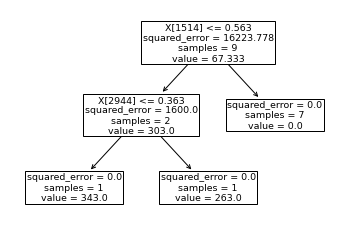

In [35]:
tree.plot_tree(my_dt)